In [1]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform, pdist, cdist
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom
from goatools import obo_parser
from functools import partial

import os
import time
import graco
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

# Distances

In [5]:
# Preparation
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
PPI_nx.remove_nodes_from([gene for gene, deg in PPI_nx.degree() if deg==1])
GDV = graco.orbits(PPI_nx)
GCV = graco.coefficients(GDV)

### TVD

#### First order

In [5]:
for tvd in ['3']:
    t1 = time.time()
    D = cdist(np.array(GCV[0][tvd]), np.array(GCV[0][tvd]), graco.functions.tvd)
    t2 = time.time()
    print(f'{tvd}: {t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/bald_sc_BioGRID_tvd{tvd}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

3: 147.75sec


#### Second order

In [4]:
for tvd in ['0']:
    t1 = time.time()
    D = cdist(np.array(GCV[1][tvd]), np.array(GCV[1][tvd]), graco.functions.tvd)
    t2 = time.time()
    print(f'{tvd}: {t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/bald_sc_BioGRID_stvd{tvd}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0: 140.60sec


#### Modified TVD (merged)

In [5]:
df = pd.concat([GCV[0]['2'].mul(GCV[0]['0']['2'], axis=0), GCV[0]['3'].mul(GCV[0]['0']['3'], axis=0)], axis=1)
df = df.groupby(level=0, axis=1).sum()
df[df.sum(axis=1) == 0] = np.nan

In [6]:
t1 = time.time()
D = cdist(np.array(df), np.array(df), graco.functions.tvd)
t2 = time.time()
print(f'modified-tvd: {t2-t1:.2f}sec')  
np.savetxt(f"{MATRIX_DIRECTORY}/bald_sc_BioGRID_modified_tvd.txt", D, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

modified-tvd: 148.37sec


#### Modified TVD (not merged)

In [11]:
df = pd.concat([GCV[0]['2'].mul(GCV[0]['0']['2'], axis=0), GCV[0]['3'].mul(GCV[0]['0']['3'], axis=0)], axis=1)

In [13]:
t1 = time.time()
D = cdist(np.array(df), np.array(df), graco.functions.tvd)
t2 = time.time()
print(f'modified-tvd: {t2-t1:.2f}sec')  
np.savetxt(f"{MATRIX_DIRECTORY}/bald_sc_BioGRID_modified_tvd_unmerged.txt", D, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

modified-tvd: 152.36sec


### Hellinger

In [3]:
_SQRT2 = np.sqrt(2) 

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

#### First order

In [42]:
for tvd in ['0', '1', '2', '3']:
    t1 = time.time()
    D = cdist(np.array(GCV[0][tvd]), np.array(GCV[0][tvd]), hellinger)
    t2 = time.time()
    print(f'{tvd}: {t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/bald_sc_BioGRID_hellinger{tvd}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0: 227.66sec
1: 222.63sec
2: 219.73sec
3: 219.18sec


#### Second order

In [6]:
for tvd in ['0']:
    t1 = time.time()
    D = cdist(np.array(GCV[1][tvd]), np.array(GCV[1][tvd]), hellinger)
    t2 = time.time()
    print(f'{tvd}: {t2-t1:.2f}sec')  
    np.savetxt(f"{MATRIX_DIRECTORY}/bald_sc_BioGRID_shellinger{tvd}.txt", D, 
               fmt='%.7f', header=' '.join(PPI_nx), comments='')

0: 217.59sec


#### Modified Hellinger (merged)

In [20]:
df = pd.concat([GCV[0]['2'].mul(GCV[0]['0']['2'], axis=0), GCV[0]['3'].mul(GCV[0]['0']['3'], axis=0)], axis=1)
df = df.groupby(level=0, axis=1).sum()
df[df.sum(axis=1) == 0] = np.nan

In [21]:
t1 = time.time()
D = cdist(np.array(df), np.array(df), hellinger)
t2 = time.time()
print(f'modified-tvd: {t2-t1:.2f}sec')  
np.savetxt(f"{MATRIX_DIRECTORY}/bald_sc_BioGRID_modified_hellinger.txt", D, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

modified-tvd: 205.73sec


#### Modified Hellinger (not merged)

In [22]:
df = pd.concat([GCV[0]['2'].mul(GCV[0]['0']['2'], axis=0), GCV[0]['3'].mul(GCV[0]['0']['3'], axis=0)], axis=1)

In [23]:
t1 = time.time()
D = cdist(np.array(df), np.array(df), graco.functions.tvd)
t2 = time.time()
print(f'modified-tvd: {t2-t1:.2f}sec')  
np.savetxt(f"{MATRIX_DIRECTORY}/bald_sc_BioGRID_modified_hellinger_unmerged.txt", D, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

modified-tvd: 139.09sec


### Tijana

In [6]:
np.savetxt(f"{CPP_DIRECTORY}/matrix.in", GDV, 
           header=f"{len(GDV)} 15", fmt='%d')

In [7]:
D_tijana = np.genfromtxt(f"{CPP_DIRECTORY}/matrix.out")
np.savetxt(f"{MATRIX_DIRECTORY}/bald_sc_BioGRID_tijana.txt", D_tijana, 
           fmt='%.7f', header=' '.join(PPI_nx), comments='')

# Clustering

In [7]:
METHOD = "kmedoids"

if not os.path.exists(f"{CLUSTERS_DIRECTORY}/{METHOD}"):
    os.makedirs(f"{CLUSTERS_DIRECTORY}/{METHOD}")

### Tijana

In [10]:
MATRIX_NAME = f"bald_sc_BioGRID_tijana"
with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
    line = f.readline()
D = np.genfromtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skip_header=1)

int2gene = dict(enumerate(line.split()))

t1 = time.time()
for n_clusters in range(2, 100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

### TVD

#### First order

In [6]:
# Individual
MATRIX_NAME = "bald_sc_BioGRID_tvd1"

with open(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", 'r') as f:
    line = f.readline()
D = np.genfromtxt(f"{MATRIX_DIRECTORY}/{MATRIX_NAME}.txt", skip_header=1)

int2gene = dict(enumerate(line.split()))

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

In [67]:
# Combinations
MATRIX_NAME0 = "bald_sc_BioGRID_tvd0"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

# MATRIX_NAME1 = "bald_sc_BioGRID_tvd1"
# D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME1}.txt", delimiter=' ')

MATRIX_NAME2 = "bald_sc_BioGRID_tvd2"
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

MATRIX_NAME3 = "bald_sc_BioGRID_tvd3"
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

D_tvd = np.nanmean(list(map(np.array,(D0_df, D2_df, D3_df))), axis=0)
int2gene = dict(enumerate(D0_df.columns))

del D0_df, D2_df, D3_df

In [68]:
MATRIX_NAME = "bald_sc_BioGRID_tvd023"

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(D_tvd, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

#### Second order

In [8]:
MATRIX_NAME0 = "bald_sc_BioGRID_hellinger0"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

MATRIX_NAME1 = "bald_sc_BioGRID_hellinger1"
D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME1}.txt", delimiter=' ')

MATRIX_NAME2 = "bald_sc_BioGRID_hellinger2"
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

MATRIX_NAME3 = "bald_sc_BioGRID_hellinger3"
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

MATRIX_NAME4 = "bald_sc_BioGRID_shellinger0"
D4_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME4}.txt", delimiter=' ')


D_tvd = np.nanmean(list(map(np.array,(D0_df, D1_df, D2_df, D3_df, D4_df))), axis=0)
int2gene = dict(enumerate(D0_df.columns))

del D0_df, D1_df, D2_df, D3_df, D4_df

In [9]:
MATRIX_NAME = "bald_sc_BioGRID_hellinger01234"

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(D_tvd, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

#### Modified

In [15]:
MATRIX_NAME0 = "bald_sc_BioGRID_tvd0"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

MATRIX_NAME2 = "bald_sc_BioGRID_tvd2"
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

MATRIX_NAME3 = "bald_sc_BioGRID_tvd3"
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

MATRIX_NAMEm = "bald_sc_BioGRID_modified_tvd_unmerged"
Dm_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAMEm}.txt", delimiter=' ')

int2gene = dict(enumerate(D0_df.columns))

In [16]:
D0 = np.array(D0_df)
D2 = np.array(D2_df)
D3 = np.array(D3_df)
Dm = np.array(Dm_df)

D023 = np.nanmean(list(map(np.array,(D0_df, D2_df, D3_df))), axis=0)
D0m1 = np.nanmean(list(map(np.array,(D0_df, Dm_df))), axis=0)
D0m2 = np.array(Dm_df.fillna(D0_df))

In [11]:
D2[np.isnan(D2)] = 0
D3[np.isnan(D3)] = 0
Dm[np.isnan(Dm)] = 0

D23[np.isnan(D23)] = 0

In [17]:
D_dict = {"bald_sc_BioGRID_modified1_tvd0_unmerged": D0m1,
          "bald_sc_BioGRID_modified2_tvd0_unmerged": D0m2}

In [18]:
t1 = time.time()
for n_clusters, (MATRIX_NAME, D) in product(range(2,100), D_dict.items()):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f"{' '.join(MATRIX_NAME.split('_')[3:])}, {n_clusters}: {t2-t1:.2f}sec", end='\r')

### Hellinger

### First order

In [6]:
MATRIX_NAME0 = "bald_sc_BioGRID_hellinger0"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

MATRIX_NAME1 = "bald_sc_BioGRID_hellinger1"
D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME1}.txt", delimiter=' ')

#MATRIX_NAME2 = "bald_sc_BioGRID_hellinger2"
#D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

#MATRIX_NAME3 = "bald_sc_BioGRID_hellinger3"
#D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

#D_hellinger = np.nanmean(list(map(np.array,(D0_df, D2_df, D3_df))), axis=0)
int2gene = dict(enumerate(D0_df.columns))

#del D2_df, D3_df

In [7]:
MATRIX_NAME = "bald_sc_BioGRID_hellinger1"

t1 = time.time()
for n_clusters in range(2,100):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(np.array(D0_df), initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

### Second Order

In [ ]:
MATRIX_NAME0 = "bald_sc_BioGRID_hellinger0"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

MATRIX_NAME1 = "bald_sc_BioGRID_hellinger1"
D1_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME1}.txt", delimiter=' ')

MATRIX_NAME2 = "bald_sc_BioGRID_hellinger2"
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

MATRIX_NAME3 = "bald_sc_BioGRID_hellinger3"
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

MATRIX_NAME4 = "bald_sc_BioGRID_shellinger0"
D4_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME4}.txt", delimiter=' ')


D_tvd = np.nanmean(list(map(np.array,(D0_df, D1_df, D2_df, D3_df, D4_df))), axis=0)
int2gene = dict(enumerate(D0_df.columns))

del D0_df, D1_df, D2_df, D3_df, D4_df

#### Modified (merged)

In [24]:
MATRIX_NAME0 = "bald_sc_BioGRID_hellinger0"
D0_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME0}.txt", delimiter=' ')

MATRIX_NAME2 = "bald_sc_BioGRID_hellinger2"
D2_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME2}.txt", delimiter=' ')

MATRIX_NAME3 = "bald_sc_BioGRID_hellinger3"
D3_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAME3}.txt", delimiter=' ')

MATRIX_NAMEm = "bald_sc_BioGRID_modified_hellinger"
Dm_df = pd.read_csv(f"{MATRIX_DIRECTORY}/{MATRIX_NAMEm}.txt", delimiter=' ')

int2gene = dict(enumerate(D0_df.columns))

In [25]:
D0 = np.array(D0_df)
D2 = np.array(D2_df)
D3 = np.array(D3_df)
Dm = np.array(Dm_df)

D023 = np.nanmean(list(map(np.array,(D0_df, D2_df, D3_df))), axis=0)
D0m1 = np.nanmean(list(map(np.array,(D0_df, Dm_df))), axis=0)
D0m2 = np.array(Dm_df.fillna(D0_df))

In [26]:
D_dict = {"bald_sc_BioGRID_modified1_hellinger0": D0m1,
          "bald_sc_BioGRID_modified2_hellinger0": D0m2}

In [27]:
t1 = time.time()
for n_clusters, (MATRIX_NAME, D) in product(range(2,100), D_dict.items()):
    initial_medoids = range(n_clusters)
    kmedoids_instance = kmedoids(D, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()

    with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'w') as f:
        for cluster in kmedoids_instance.get_clusters():
            f.write(' '.join(map(int2gene.get,cluster)) + '\n')
    t2 = time.time()
    print(f"{' '.join(MATRIX_NAME.split('_')[3:])}, {n_clusters}: {t2-t1:.2f}sec", end='\r')

# Annotations

#### Preparation

In [3]:
# Load PPI
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
PPI_nx.remove_nodes_from([gene for gene, deg in PPI_nx.degree() if deg==1])

# Load obo file
GO_FILENAME = "go-basic.obo"
GO_FILEPATH = f"{RAW_DATA_DIRECTORY}/{GO_FILENAME}"
go_dag = obo_parser.GODag(GO_FILEPATH)

/home/clusterduck123/Desktop/git/supplements/data/raw_data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


In [4]:
all_BP_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_BP_sc.csv")
all_MF_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_MF_sc.csv")
all_CC_annotations_df = pd.read_csv(f"{ANNOTATIONS_DIRECTORY}/SGD_CC_sc.csv")

In [5]:
PPI_BP_annotations_df = all_BP_annotations_df[all_BP_annotations_df.Systematic_ID.isin(PPI_nx.nodes)]
PPI_MF_annotations_df = all_MF_annotations_df[all_MF_annotations_df.Systematic_ID.isin(PPI_nx.nodes)]
PPI_CC_annotations_df = all_CC_annotations_df[all_CC_annotations_df.Systematic_ID.isin(PPI_nx.nodes)]

In [6]:
annotation_df = PPI_BP_annotations_df
GO_population = {go_id for go_id in set(annotation_df.GO_ID) 
                           if (5 <= len(annotation_df[annotation_df.GO_ID == go_id]) <= 500 and
                               go_dag[go_id].level > -1)}

annotation_df = annotation_df[annotation_df.GO_ID.isin(GO_population)]

In [7]:
# Conversion dictionaries
int2GO = dict(enumerate(GO_population))
GO2int = dict(zip(int2GO.values(), int2GO.keys()))

GO2genes = {go_id:set(annotation_df.Systematic_ID[annotation_df.GO_ID == go_id])
                for go_id in GO_population}

gene2GOs = {gene :set(annotation_df.GO_ID[annotation_df.Systematic_ID == gene]) 
                for gene  in set(annotation_df.Systematic_ID)}

# Enrichement

In [8]:
# List of success states
list_of_success_states = list(GO2genes.values())

# This will be our K, see below. Reshped to fit the shape of k 'array_of_observed_successes'
array_of_total_successes = np.array(list(map(len,list_of_success_states))).reshape(-1,1)

In [9]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100
alpha = [0.01, 0.05, 0.1]

hc_cluster_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
mc_cluster_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
lc_cluster_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))

hc_GO_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
mc_GO_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
lc_GO_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))

hc_gene_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
mc_gene_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))
lc_gene_coverage = defaultdict(partial(np.ndarray, MAX_CLUSTERS-MIN_CLUSTERS))

In [20]:
METHOD = "kmedoids"

for distance in [
                 "bald_sc_BioGRID_tijana",
                ]:
    print(distance)
    MATRIX_NAME = f"{distance}"

    t1 = time.time()
    for i, n_clusters in enumerate(range(2, MAX_CLUSTERS)):

        with open(f"{CLUSTERS_DIRECTORY}/{METHOD}/{MATRIX_NAME}_{n_clusters}.txt", 'r') as f:
            clusters = list(map(str.split, f))

        list_of_experiments = list(map(set,clusters))

        # For each GO term and cluster we get an experiment 
        array_of_observed_successes = np.array([[len(draws & success_states) for draws in list_of_experiments]
                                            for success_states in list_of_success_states])


        N = sum(map(len,clusters))       # PPI size, i.e. number of all genes that appear in a cluster
        K = array_of_total_successes     # defined in section 'Preparation'
        n = list(map(len, clusters))     # cluster lengths
        k = array_of_observed_successes 

        # scipy has a really messed up nomeclature... 
        p_values_array = 1-hypergeom.cdf(k=k-1, M=N, N=n, n=K)
        p_values_df    = pd.DataFrame(p_values_array, index=GO_population)
        GO_index = p_values_df.index

        m = p_values_array.size

        hc_enrichment_df = p_values_df < alpha[0]/m
        mc_enrichment_df = p_values_df < alpha[1]/m
        lc_enrichment_df = p_values_df < alpha[2]/m

        # Calculate cluster coverage
        hc_cluster_coverage[distance][i] = sum(hc_enrichment_df.any())/n_clusters
        mc_cluster_coverage[distance][i] = sum(mc_enrichment_df.any())/n_clusters
        lc_cluster_coverage[distance][i] = sum(lc_enrichment_df.any())/n_clusters

        # Calculate GO-term coverage
        hc_GO_coverage[distance][i] = sum(hc_enrichment_df.any(axis=1))/len(GO_population)
        mc_GO_coverage[distance][i] = sum(mc_enrichment_df.any(axis=1))/len(GO_population)
        lc_GO_coverage[distance][i] = sum(lc_enrichment_df.any(axis=1))/len(GO_population)

        # Calculate gene coverage
        hc_gene_coverage[distance][i] = sum(1 for (nr, cluster) in enumerate(clusters) for gene in cluster 
                                                if gene2GOs.get(gene, set()) & set(GO_index[hc_enrichment_df[nr]]))/N
        mc_gene_coverage[distance][i] = sum(1 for (nr, cluster) in enumerate(clusters) for gene in cluster 
                                                if gene2GOs.get(gene, set()) & set(GO_index[mc_enrichment_df[nr]]))/N
        lc_gene_coverage[distance][i] = sum(1 for (nr, cluster) in enumerate(clusters) for gene in cluster 
                                                if gene2GOs.get(gene, set()) & set(GO_index[lc_enrichment_df[nr]]))/N

        t2 = time.time()
        print(f'{n_clusters}: {t2-t1:.2f}sec', end='\r')

bald_sc_BioGRID_tijana


# Plots

In [25]:
plot_distances = [
#    "bald_sc_BioGRID_hellinger0123",
    "bald_sc_BioGRID_tvd01234","bald_sc_BioGRID_hellinger01234",
    "bald_sc_BioGRID_tijana"
#    "bald_sc_BioGRID_hellinger1",
#    "bald_sc_BioGRID_hellinger0",
    
 #   "bald_sc_BioGRID_tvd0123",
#    "bald_sc_BioGRID_tvd1",
#    "bald_sc_BioGRID_tvd0"
                ]

name2string = {"bald_sc_BioGRID_tijana": "Tijana",
               
               "bald_sc_BioGRID_tvd0": "TVD_{0}",
               "bald_sc_BioGRID_tvd1": "TVD_{1}",
               "bald_sc_BioGRID_tvd2": "TVD_{2}",
               "bald_sc_BioGRID_tvd3": "TVD_{3}",
               
               "bald_sc_BioGRID_tvd01234": "TVD_{01234}",
               "bald_sc_BioGRID_tvd0123": "TVD_{0123}",
               "bald_sc_BioGRID_tvd023": "TVD_{023}",
               
               "bald_sc_BioGRID_hellinger0": "hellinger_{0}",
               "bald_sc_BioGRID_hellinger1": "hellinger_{1}",
               "bald_sc_BioGRID_hellinger2": "hellinger_{2}",
               "bald_sc_BioGRID_hellinger3": "hellinger_{3}",
               
               "bald_sc_BioGRID_hellinger01234": "hellinger_{01234}",
               "bald_sc_BioGRID_hellinger0123": "hellinger_{0123}",
               "bald_sc_BioGRID_hellinger023" : "hellinger_{023}"}

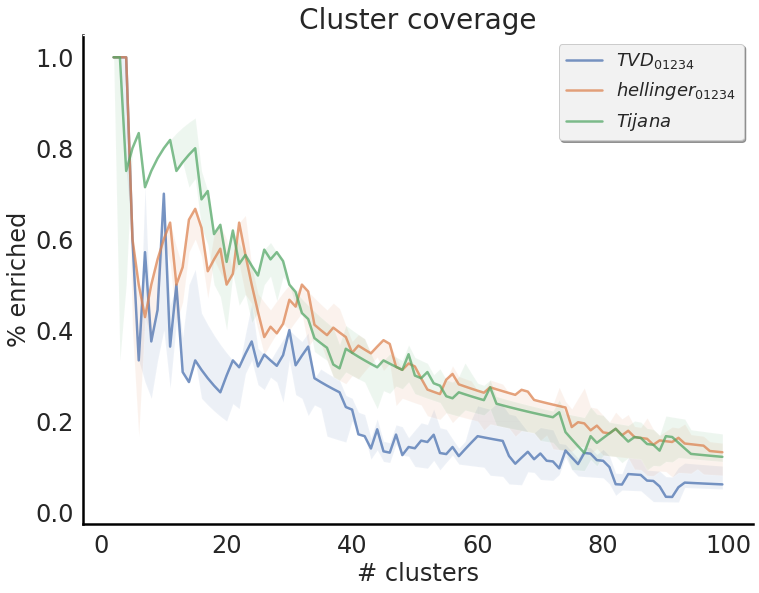

In [26]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for distance in plot_distances:
    ax.plot(range(2,MAX_CLUSTERS), mc_cluster_coverage[distance], 
            label=f'${name2string[distance]}$', 
            linewidth=2.5,
            alpha=0.75);
    
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     hc_cluster_coverage[distance], 
                     lc_cluster_coverage[distance], 
                     alpha=0.1,);
    ax.set_title('Cluster coverage', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy1.png")

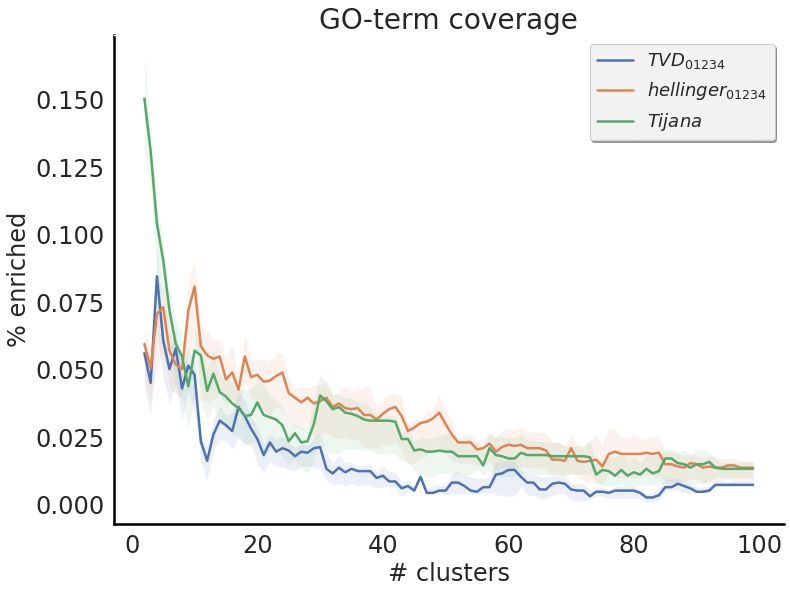

In [27]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

for distance in plot_distances:
    
    ax.plot(range(2,MAX_CLUSTERS), mc_GO_coverage[distance], 
             label=f'${name2string[distance]}$', 
             linewidth=2.5);
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     hc_GO_coverage[distance], 
                     lc_GO_coverage[distance], 
                     alpha=0.1);
    ax.set_title('GO-term coverage', fontsize=28)
    
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy2.png")

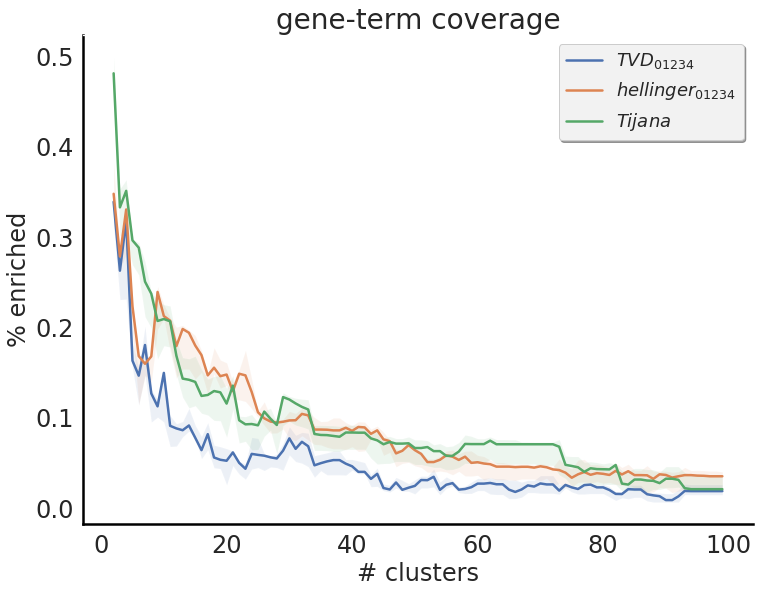

In [28]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

for distance in plot_distances:
    
    ax.plot(range(2,MAX_CLUSTERS), mc_gene_coverage[distance], 
             label=f'${name2string[distance]}$', 
             linewidth=2.5);
    ax.fill_between(range(2,MAX_CLUSTERS), 
                     hc_gene_coverage[distance], 
                     lc_gene_coverage[distance], 
                     alpha=0.1);
    ax.set_title('gene-term coverage', fontsize=28)
    
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0]);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy3.png")

# Test